# Stratified KFold for the OM dataset

This code helps split a dataset in COCO (+ YOLO later) format given labels distributions across the dataset. This algorithm is indended for preserving the samples percentages for each class in order to provide a smoother generalization and adress class imbalance. 

## Setup

In [2]:
import json
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np
import os

## Load the dataset

In [3]:
dataset_path = './roboflow_datasets/xmm_om_artefacts_512-28-COCO/'
json_file_path = dataset_path+'train/_annotations.coco.json'
dest_path = './roboflow_datasets/xmm_om_artefacts_512-28-COCO-splits/'

with open(json_file_path) as f:
    data_in = json.load(f)
data_in['categories']

# create the destination folder if it doesn't exist already
if not os.path.exists(dest_path):
    os.mkdir(dest_path)

In [4]:
data_in['categories']

[{'id': 0, 'name': 'artefacts', 'supercategory': 'none'},
 {'id': 1, 'name': 'central-ring', 'supercategory': 'artefacts'},
 {'id': 2, 'name': 'other', 'supercategory': 'artefacts'},
 {'id': 3, 'name': 'read-out-streak', 'supercategory': 'artefacts'},
 {'id': 4, 'name': 'smoke-ring', 'supercategory': 'artefacts'},
 {'id': 5, 'name': 'star-loop', 'supercategory': 'artefacts'}]

In [4]:
# # running the script multiple times may change the redistribution, 
# # thus we need to make sure that we won't keep the old files

# import glob

# files = glob.glob(f'{dest_path}/*')

# for file in files:
#     os.remove(file)

## Stratified KFold

In [5]:
images, labels = [], []

for k in range(len(data_in['images'])):
    img_id = data_in['images'][k]['id']
    annotations = [data_in['annotations'][j] for j in range(len(data_in['annotations'])) if data_in['annotations'][j]['image_id'] == img_id]
    categories = set(str(annot['category_id']) for annot in annotations)
    images.append([img_id])
    labels.append(''.join(list(categories)))
        
images, labels = np.array(images), np.array(labels)

In [6]:
np.unique(labels).shape

(23,)

The resulting arrays' size equals to the number of annotations because image ids are repeated for each label associated with them.

In [7]:
images.shape, labels.shape

((1019, 1), (1019,))

Run the Stratified KFold split and generate train and valid datasets given the number of splits. 

The split percentage is calculated depending on the `n_splits` parameter:

> train_percentage = int(100 * 1/n_splits)
>
> valid_percentage = 100 - train_percentage

In [8]:
skf_image_ids, skf_labels, kf_image_ids, kf_labels = {}, {}, {}, {}

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# skf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

for i, (train_index, valid_index) in enumerate(skf.split(images, labels)):
    skf_image_ids[i] = {'train': images[train_index], 'valid': images[valid_index]}
    skf_labels[i] = {'train': labels[train_index], 'valid': labels[valid_index]}

for i, (train_index, valid_index) in enumerate(kf.split(images, labels)):
    kf_image_ids[i] = {'train': images[train_index], 'valid': images[valid_index]}
    kf_labels[i] = {'train': labels[train_index], 'valid': labels[valid_index]}

/opt/conda/envs/env_py311/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [9]:
len(train_index), len(valid_index)

(765, 254)

In [10]:
len(skf_image_ids), 'splits'

(4, 'splits')

**Ensure that there are no image ids present in both splits.**

In [11]:
for i in range(n_splits):
    print("intersection", len(np.intersect1d(skf_image_ids[i]['train'], skf_image_ids[i]['valid'])))

intersection 0
intersection 0
intersection 0
intersection 0


**Ensure that the labels distribution is roughly the same between splits.**

In [12]:

def percentages(n_splits, image_ids, labels):
    labels_percentages = {}
    for i in range(n_splits):
        train_k, valid_k = 0, 0
        train_labels_counts = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
        valid_labels_counts = {'0':0, '1':0, '2':0, '3':0, '4':0, '5':0}
        for j in range(len(image_ids[i]['train'])):
            for cat in list(labels[i]['train'][j]):
                train_labels_counts[cat] += 1
                train_k+=1
        
        for j in range(len(image_ids[i]['valid'])):
            for cat in list(labels[i]['valid'][j]):
                valid_labels_counts[cat] += 1
                valid_k+=1
    
        train_labels_counts = {cat:counts * 1.0/train_k for cat, counts in train_labels_counts.items()}
        valid_labels_counts = {cat:counts * 1.0/valid_k for cat, counts in valid_labels_counts.items()}
                
        labels_percentages[i] = {'train':train_labels_counts, 'valid':  valid_labels_counts}
        
    return labels_percentages

In [13]:
labels_percentages_skf = percentages(n_splits, skf_image_ids, skf_labels)
labels_percentages_kf = percentages(n_splits, kf_image_ids, kf_labels)
labels_percentages_skf

{0: {'train': {'0': 0.0,
   '1': 0.2576008844665561,
   '2': 0.007739082365948038,
   '3': 0.23880597014925373,
   '4': 0.2222222222222222,
   '5': 0.2736318407960199},
  'valid': {'0': 0.0,
   '1': 0.2607260726072607,
   '2': 0.006600660066006601,
   '3': 0.2376237623762376,
   '4': 0.22442244224422442,
   '5': 0.2706270627062706}},
 1: {'train': {'0': 0.0,
   '1': 0.2585446527012128,
   '2': 0.007166482910694598,
   '3': 0.23759647188533628,
   '4': 0.22381477398015434,
   '5': 0.272877618522602},
  'valid': {'0': 0.0,
   '1': 0.2579034941763727,
   '2': 0.008319467554076539,
   '3': 0.24126455906821964,
   '4': 0.21963394342762063,
   '5': 0.27287853577371046}},
 2: {'train': {'0': 0.0,
   '1': 0.25897294312534513,
   '2': 0.00717835450027609,
   '3': 0.2390944229707344,
   '4': 0.22308117062396465,
   '5': 0.27167310877967976},
  'valid': {'0': 0.0,
   '1': 0.25662251655629137,
   '2': 0.008278145695364239,
   '3': 0.2367549668874172,
   '4': 0.22185430463576158,
   '5': 0.27649006

In [14]:
labels_percentages_kf

{0: {'train': {'0': 0.0,
   '1': 0.26170798898071623,
   '2': 0.007713498622589532,
   '3': 0.23856749311294767,
   '4': 0.22258953168044077,
   '5': 0.2694214876033058},
  'valid': {'0': 0.0,
   '1': 0.24833333333333332,
   '2': 0.006666666666666667,
   '3': 0.23833333333333334,
   '4': 0.22333333333333333,
   '5': 0.2833333333333333}},
 1: {'train': {'0': 0.0,
   '1': 0.256198347107438,
   '2': 0.007162534435261708,
   '3': 0.2413223140495868,
   '4': 0.2209366391184573,
   '5': 0.2743801652892562},
  'valid': {'0': 0.0,
   '1': 0.265,
   '2': 0.008333333333333333,
   '3': 0.23,
   '4': 0.22833333333333333,
   '5': 0.2683333333333333}},
 2: {'train': {'0': 0.0,
   '1': 0.25686059275521406,
   '2': 0.00823271130625686,
   '3': 0.23874862788144896,
   '4': 0.221185510428101,
   '5': 0.27497255762897915},
  'valid': {'0': 0.0,
   '1': 0.2630691399662732,
   '2': 0.00505902192242833,
   '3': 0.23777403035413153,
   '4': 0.22765598650927488,
   '5': 0.26644182124789206}},
 3: {'train': {'

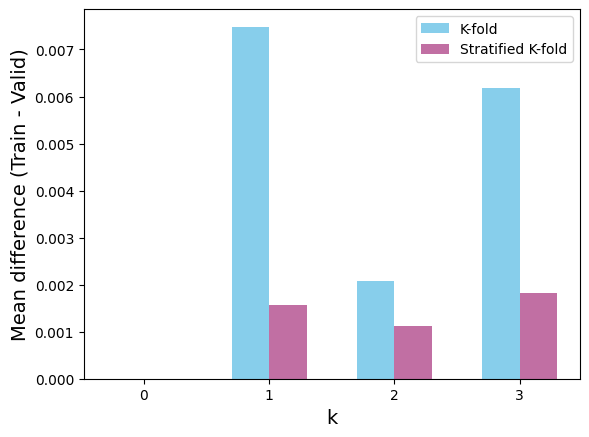

In [15]:
import matplotlib.pyplot as plt
import numpy as np

results = labels_percentages_kf
results_skf = labels_percentages_skf

colors = ['#89D8CD', '#9F156480', '#FFBCF880', '#FFBCF880', '#FFBCF880']

label_diffs = {i: {label: abs(results[i]['train'][label] - results[i]['valid'][label])
                   for label in results[i]['train']} for i in results}
label_diffs_skf = {i: {label: abs(results_skf[i]['train'][label] - results_skf[i]['valid'][label])
                   for label in results_skf[i]['train']} for i in results_skf}

diff_array = np.array([[label_diffs[iteration][label] for label in sorted(label_diffs[iteration])]
                       for iteration in sorted(label_diffs)])
mean_array = np.array([np.mean(diff_array[:, i]) for i in range(diff_array.shape[0])])

diff_array_skf = np.array([[label_diffs_skf[iteration][label] for label in sorted(label_diffs_skf[iteration])]
                       for iteration in sorted(label_diffs_skf)])
mean_array_skf = np.array([np.mean(diff_array_skf[:, i]) for i in range(diff_array_skf.shape[0])])


indices = np.arange(len(mean_array))
# bar width
width = 0.3

fig, ax = plt.subplots()
bars1 = ax.bar(indices - width/2, mean_array, width, label='K-fold', color='skyblue')
bars2 = ax.bar(indices + width/2, mean_array_skf, width, label='Stratified K-fold', color='#C16FA3')

plt.xlabel('k', fontsize=14)
plt.ylabel('Mean difference (Train - Valid)', fontsize=14)
ax.set_xticks(indices)
ax.set_xticklabels([str(i) for i in indices])
ax.legend()
plt.savefig('./plots/kf_skf_errors.png', dpi=400)
plt.show()

In [16]:
mean_array, mean_array_skf

(array([0.        , 0.00748357, 0.00208623, 0.00618994]),
 array([0.        , 0.00156485, 0.0011248 , 0.00183035]))

In [17]:
diff_array.shape, diff_array_skf

((4, 6),
 array([[0.00000000e+00, 3.12518814e-03, 1.13842230e-03, 1.18220777e-03,
         2.20022002e-03, 3.00477809e-03],
        [0.00000000e+00, 6.41158525e-04, 1.15298464e-03, 3.66808718e-03,
         4.18083055e-03, 9.17251108e-07],
        [0.00000000e+00, 2.35042657e-03, 1.09979120e-03, 2.33945608e-03,
         1.22686599e-03, 4.81695745e-03],
        [0.00000000e+00, 1.42616315e-04, 1.10801906e-03, 1.31645829e-04,
         3.18875452e-03, 1.80647332e-03]]))

In [18]:
np.mean(diff_array[:, 0])

0.0

In [19]:
diff_array

array([[0.        , 0.01337466, 0.00104683, 0.00023416, 0.0007438 ,
        0.01391185],
       [0.        , 0.00880165, 0.0011708 , 0.01132231, 0.00739669,
        0.00604683],
       [0.        , 0.00620855, 0.00317369, 0.0009746 , 0.00647048,
        0.00853074],
       [0.        , 0.00154943, 0.00295361, 0.01222869, 0.01421749,
        0.00058462]])

## Update the dataset and save new annotations files

In [20]:
import shutil
import os

def make_split(data_in, train_index, valid_index):
    
    data_in_train = data_in.copy()
    data_in_valid = data_in.copy()
    
    data_in_train['images'] = [data_in['images'][train_index[i][0]] for i in range(len(train_index))]
    data_in_valid['images'] = [data_in['images'][valid_index[i][0]] for i in range(len(valid_index))]
    train_annot_ids, valid_annot_ids = [], []
    
    for img_i in data_in_train['images']:
        annotation_ids = [annot['id'] for annot in data_in_train['annotations'] if annot['image_id'] == img_i['id']]
        train_annot_ids +=annotation_ids
        
    for img_i in data_in_valid['images']:
        annotation_ids = [annot['id'] for annot in data_in_valid['annotations'] if annot['image_id'] == img_i['id']]
        valid_annot_ids +=annotation_ids
        
    data_in_train['annotations'] = [data_in_train['annotations'][id] for id in train_annot_ids]
    data_in_valid['annotations'] = [data_in_valid['annotations'][id] for id in valid_annot_ids]
    
    print(len(data_in_train['images']), len(data_in_valid['images']))
    return data_in_train, data_in_valid

for i in range(n_splits):
    dest_train_path_i = dest_path + f'train_{i+1}/'
    dest_valid_path_i = dest_path + f'valid_{i+1}/'
    os.mkdir(dest_train_path_i)
    os.mkdir(dest_valid_path_i)
    new_train_json_path = dest_train_path_i+'skf_train_annotations.coco.json'
    new_valid_json_path = dest_valid_path_i+'skf_valid_annotations.coco.json'
    data_in_train_i, data_in_valid_i = make_split(data_in, skf_image_ids[i]['train'], skf_image_ids[i]['valid'])

    with open(new_train_json_path, 'w') as f1, open(new_valid_json_path, 'w') as f2:
        json.dump(data_in_train_i, f1, indent=4)
        json.dump(data_in_valid_i, f2, indent=4)

    # Copy the filenames to the corresponding split directories
    train_filenames_i = list(set([image['file_name'] for image in data_in_train_i['images']]))
    valid_filenames_i = list(set([image['file_name'] for image in data_in_valid_i['images']]))
    print(len(train_filenames_i), len(valid_filenames_i))
    
    for filename in train_filenames_i:
        source_path = os.path.join(dataset_path+'train/', filename)
        dest_path_f = os.path.join(dest_train_path_i, filename)
        shutil.copy(source_path, dest_path_f)

    for filename in valid_filenames_i:
        source_path = os.path.join(dataset_path+'train/', filename)
        dest_path_f = os.path.join(dest_valid_path_i, filename)
        shutil.copy(source_path, dest_path_f)
    
    print("Files moved successfully.")

764 255
764 255
Files moved successfully.
764 255
764 255
Files moved successfully.
764 255
764 255
Files moved successfully.
765 254
765 254
Files moved successfully.


# Convert COCO annotations to YOLO segmentation (Optional)

In [6]:
# TODO: convert to YOLO segm, not bbox only
from dataset import coco_to_yolo_converter
import yaml 

convert = True

if convert:

    classes = [str(cat['name']) for cat in data_in['categories'] if 'artefacts' not in cat['name']]
    absolute_path = '/workspace/raid/OM_DeepLearning/XMM_OM_code_git/'
    for iter in range(1,4+1):
        for mode in ['train', 'valid']:
            
            input_path = f"./roboflow_datasets/xmm_om_artefacts_512-28-COCO-splits/{mode}_{iter}/"

            # adding '/' at the end will give an error for the parent directory
            output_path = f"./roboflow_datasets/xmm_om_artefacts_512-28-YOLO-splits/{mode}_{iter}" 
            input_json_train = f"skf_{mode}_annotations.coco.json"
            converter = coco_to_yolo_converter.COCOToYOLOConverter(input_path, output_path, input_json_train, plot_yolo_masks=False)
            converter.convert()
            
            # generate data.yaml
            yaml_path = os.path.dirname(output_path)+f'/_{iter}_data.yaml'

            # Create the initial data structure
            if mode =='valid': # train and valid folder successfully created
                yolo_data = {
                    'names': classes,
                    'nc': len(classes),
                    'train': f'{os.path.join(absolute_path, os.path.dirname(output_path)).replace(".", "").replace("//", "/")}/train_{iter}/images',
                    'val': f'{os.path.join(absolute_path, os.path.dirname(output_path)).replace(".", "").replace("//", "/")}/valid_{iter}/images'
                }
                
                # Write the data to a YAML file
                with open(yaml_path, 'w') as file:
                    yaml.dump(yolo_data, file, default_flow_style=False)
                
                print(f"YAML file {yaml_path} created and saved.")

Processed 764 files.
Processed 255 files.
YAML file ./roboflow_datasets/xmm_om_artefacts_512-28-YOLO-splits/_1_data.yaml created and saved.
Processed 764 files.
Processed 255 files.
YAML file ./roboflow_datasets/xmm_om_artefacts_512-28-YOLO-splits/_2_data.yaml created and saved.
Processed 764 files.
Processed 255 files.
YAML file ./roboflow_datasets/xmm_om_artefacts_512-28-YOLO-splits/_3_data.yaml created and saved.
Processed 765 files.
Processed 254 files.
YAML file ./roboflow_datasets/xmm_om_artefacts_512-28-YOLO-splits/_4_data.yaml created and saved.
